# Sound Fingerprinting

Classical FFT spectrogram time: 0.0425522 s


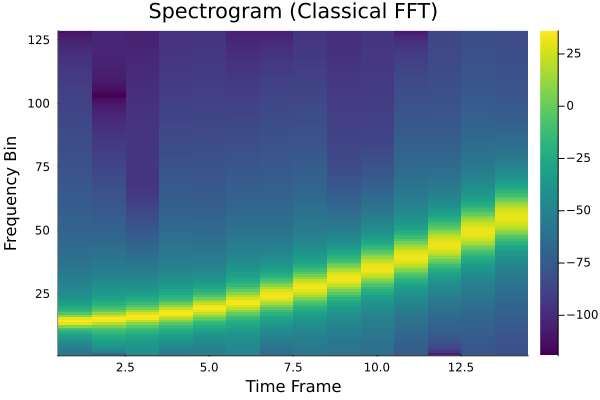

In [1]:
### Classical FFT Version

using FFTW
using Plots
using LinearAlgebra

# ─── PARAMETERS ────────────────────────────────────────────────────────────
fs, duration = 1000, 2.0
f0, f1       = 50, 250

# time vector & signal
t = 0:1/fs:duration-1/fs
x = cos.(2π .* t .* (f0 .+ (f1 - f0) .* t.^2 ./ (3 * duration^2)))

# STFT params
n_fft    = 256
hop_size = n_fft ÷ 2
window   = 0.5 .- 0.5*cos.(2π*(0:n_fft-1)./(n_fft-1))
n_frames = (length(x) - n_fft) ÷ hop_size + 1

# allocate
spec_fft = zeros(n_fft ÷ 2, n_frames)

# time the FFT‐based STFT
fft_time = @elapsed begin
    for i in 1:n_frames
        idx   = (i-1)*hop_size + 1
        frame = x[idx:idx+n_fft-1] .* window
        spec_fft[:, i] = abs.(fft(frame)[1:(n_fft ÷ 2)])
    end
end

println("Classical FFT spectrogram time: $(round(fft_time, sigdigits=6)) s")

# plot
spec_db = 20 .* log10.(spec_fft .+ 1e-6)
heatmap(
    spec_db;
    xlabel="Time Frame",
    ylabel="Frequency Bin",
    title="Spectrogram (Classical FFT)",
    colorbar=true,
    aspect_ratio=:auto,
    c=:viridis
)


Loading QFT MPO from Basis states Final/MPO_8.h5…
Preloading 256 basis MPS for inner products…
QFT-MPO spectrogram time: 0.00151367 s


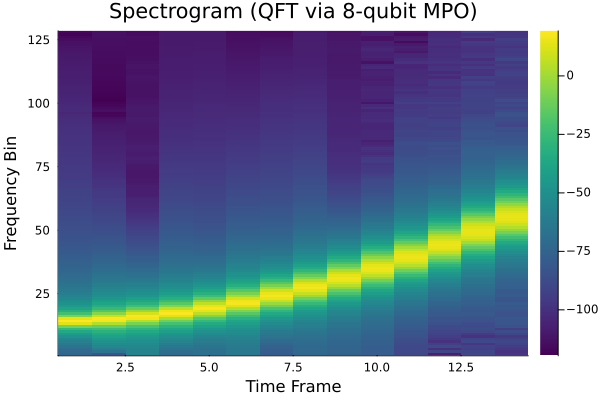

In [6]:
using ITensors
using ITensorMPS
using HDF5
using LinearAlgebra
using Plots

# ─── PARAMETERS ───────────────────────────────────────────────────────────────
fs       = 1000                  # sampling rate (Hz)
duration = 2.0                   # signal duration (s)
f0, f1   = 50, 250               # chirp from 50 → 250 Hz

# ─── SYNTHETIC CHIRP SIGNAL ──────────────────────────────────────────────────
t = 0:1/fs:duration-1/fs
x = cos.(2π .* t .* (f0 .+ (f1 - f0) .* t.^2 ./ (3 * duration^2)))

# ─── STFT PARAMETERS ─────────────────────────────────────────────────────────
n_fft    = 256                   # FFT length → 2^8 = 8 qubits
half     = n_fft ÷ 2             # positive‐frequency bins
hop_size = n_fft ÷ 2             # 50% overlap
window   = 0.5 .- 0.5*cos.(2π*(0:n_fft-1)./(n_fft-1))  # Hann window
n_frames = (length(x) - n_fft) ÷ hop_size + 1

# ─── LOAD 8-QUBIT QFT MPO ─────────────────────────────────────────────────────
mpo_path = "Basis states Final/MPO_8.h5"
println("Loading QFT MPO from $mpo_path…")
W = h5open(mpo_path, "r") do f
  read(f, "W", MPO)
end

# extract the physical “ket” index on each MPO site (should be 8 qubits)
site_inds   = [pair[2] for pair in siteinds(W)]
num_qubits  = length(site_inds)
scale       = 2^(num_qubits/2)    # normalization factor = √(2^num_qubits) = √n_fft

# ─── PRELOAD QFT BASIS STATES ────────────────────────────────────────────────
println("Preloading $n_fft basis MPS for inner products…")
MPS2 = Vector{MPS}(undef, n_fft)
for k in 1:n_fft
  basis_path = "Basis states Final/MPS_8/MPS_create_$k.h5"
  h5open(basis_path, "r") do f
    MPS2[k] = read(f, "M", MPS)
  end
end

# ─── PREALLOCATE SPECTROGRAM MATRIX ─────────────────────────────────────────
spec_qft = zeros(Float64, half, n_frames)

# ─── RUN & TIME THE QFT-MPO STFT ────────────────────────────────────────────

  for frame_idx in 1:n_frames
    # 1) extract & window one frame
    i0    = (frame_idx-1)*hop_size + 1
    frame = x[i0:i0+n_fft-1] .* window

    # 2) build normalized MPS
    T   = ITensor(frame ./ norm(frame), site_inds...)
    ψ   = MPS(T, site_inds; cutoff=1e-24, maxdim=10)
    orthogonalize!(ψ, 1)

    qft_time = @elapsed begin
    # 3) apply QFT as an MPO to your MPS
    result = contract(W, ψ)  # returns a Vector{ITensor}
    end
    # 4) compute inner products vs. basis, scale, & take magnitude
    amps = [ inner(MPS2[k], result) * scale for k in 1:n_fft ]
    spec_qft[:, frame_idx] .= abs.(amps[1:half])
  
end

println("QFT-MPO spectrogram time: $(round(qft_time, sigdigits=6)) s")

# ─── PLOT THE SPECTROGRAM ────────────────────────────────────────────────────
spec_db = 20 .* log10.(spec_qft .+ 1e-6)  # dB scale with floor
heatmap(
  spec_db;
  xlabel="Time Frame",
  ylabel="Frequency Bin",
  title="Spectrogram (QFT via $(num_qubits)-qubit MPO)",
  colorbar=true,
  aspect_ratio=:auto,
  c=:viridis
)
